# BERT Classification: Raw Fixations (FPOGX, FPOGY) with LOUO

This notebook trains a BERT model to classify literate vs illiterate users based on raw eye-tracking fixations.

**Data Format:** Each row is tokenized as `x,y` coordinates with `[ROW]` separators
**Features:** FPOGX and FPOGY only (rounded to 0.01)
**Evaluation:** Leave-One-User-Out Cross-Validation

## Import Libraries

In [1]:
import os
import glob
import re
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import AdamW

# Fix for torch.utils._pytree compatibility issue
if not hasattr(torch.utils._pytree, 'register_pytree_node'):
    torch.utils._pytree.register_pytree_node = lambda *args, **kwargs: None

from transformers import (
    BertTokenizer, 
    BertForSequenceClassification, 
    get_linear_schedule_with_warmup
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

Using device: cuda


In [2]:
print("System Information:")
print("="*60)
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Count: {torch.cuda.device_count()}")
else:
    print("No GPU detected - will use CPU")
print("="*60)

System Information:
PyTorch Version: 2.1.2+cu118
CUDA Available: True
CUDA Version: 11.8
GPU Device: NVIDIA GeForce RTX 3050 Laptop GPU
GPU Count: 1


## System Diagnostics

## Configuration

In [3]:
# Data configuration
DATA_PATH = "../data/raw_fixations/all"

# BERT configuration
MODEL_NAME = 'bert-base-uncased'
MAX_LENGTH = 512  # BERT maximum sequence length
BATCH_SIZE = 4
LEARNING_RATE = 2e-5
NUM_EPOCHS = 5
WARMUP_STEPS = 100
MAX_GRAD_NORM = 1.0
GRADIENT_ACCUMULATION_STEPS = 1

## Custom Dataset with Row-wise Tokenization

Format: `[CLS] 0.50,0.36 [ROW] 0.47,0.26 [ROW] ... [SEP]`

Each fixation point (FPOGX, FPOGY) is formatted as `x,y` and separated by `[ROW]` tokens.

In [4]:
class FixationsDataset(Dataset):
    """Dataset for raw fixation coordinates with custom tokenization."""
    
    def __init__(self, data_path):
        """
        Load fixation data from nested user folders.
        
        Args:
            data_path: Path to data (e.g., '../data/raw_fixations/all')
        """
        self.data = []
        self.labels = []
        self.user_ids = []
        
        # Iterate through literate and illiterate folders
        for label, label_name in enumerate(['literate', 'illiterate']):
            label_path = os.path.join(data_path, label_name)
            
            if not os.path.exists(label_path):
                print(f"Warning: {label_path} does not exist")
                continue
                
            # Iterate through user folders
            for user_folder in os.listdir(label_path):
                user_path = os.path.join(label_path, user_folder)
                
                if not os.path.isdir(user_path):
                    continue
                
                # Extract user_id from folder name (e.g., 'user_2' -> 2)
                user_id = int(user_folder.split('_')[1])
                
                # Process all CSV files in this user's folder
                for csv_file in glob.glob(os.path.join(user_path, '*.csv')):
                    try:
                        # Read CSV and extract FPOGX and FPOGY columns
                        df = pd.read_csv(csv_file)
                        
                        # Check if required columns exist
                        if 'FPOGX' not in df.columns or 'FPOGY' not in df.columns:
                            print(f"Warning: Missing FPOGX/FPOGY in {csv_file}")
                            continue
                        
                        # Extract and round coordinates to 0.01
                        fpogx = df['FPOGX'].round(2).values
                        fpogy = df['FPOGY'].round(2).values
                        
                        # Format as "x,y [ROW] x,y [ROW] ..."
                        coordinate_pairs = [f"{x:.2f},{y:.2f}" for x, y in zip(fpogx, fpogy)]
                        text = "[CLS] " + " [ROW] ".join(coordinate_pairs) + " [SEP]"
                        
                        self.data.append(text)
                        self.labels.append(label)
                        self.user_ids.append(user_id)
                        
                    except Exception as e:
                        print(f"Error processing {csv_file}: {e}")
                        continue
        
        print(f"Loaded {len(self.data)} samples from {len(set(self.user_ids))} users")
        print(f"Label distribution - Literate: {sum(1 for l in self.labels if l == 0)}, Illiterate: {sum(1 for l in self.labels if l == 1)}")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return {
            'text': self.data[idx],
            'label': self.labels[idx],
            'user_id': self.user_ids[idx]
        }
    
    def get_user_ids(self):
        """Return list of all user IDs."""
        return self.user_ids
    
    def get_unique_users(self):
        """Return sorted list of unique user IDs."""
        return sorted(set(self.user_ids))

## Load BERT Model and Tokenizer

Add `[ROW]` as a special token to handle our custom format.

In [5]:
# Initialize tokenizer and add [ROW] as special token
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
tokenizer.add_special_tokens({'additional_special_tokens': ['[ROW]']})

print(f"Tokenizer vocabulary size: {len(tokenizer)}")
print(f"Special tokens: {tokenizer.all_special_tokens}")

Tokenizer vocabulary size: 30523
Special tokens: ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]', '[ROW]']


## Token Statistics

Analyze token counts for all samples to understand sequence length distribution.

Loaded 1499 samples from 30 users
Label distribution - Literate: 650, Illiterate: 849
Calculating token statistics for all samples...


Tokenizing samples: 100%|██████████| 1499/1499 [00:04<00:00, 340.06it/s]



Token Count Statistics:
  Total samples: 1499
  Mean: 444.44
  Std: 344.67
  Min: 41
  Max: 3593
  Median: 345.00
  25th percentile: 225.00
  75th percentile: 553.00
  95th percentile: 1108.20
  99th percentile: 1697.92

Samples exceeding MAX_LENGTH (512): 429 (28.62%)


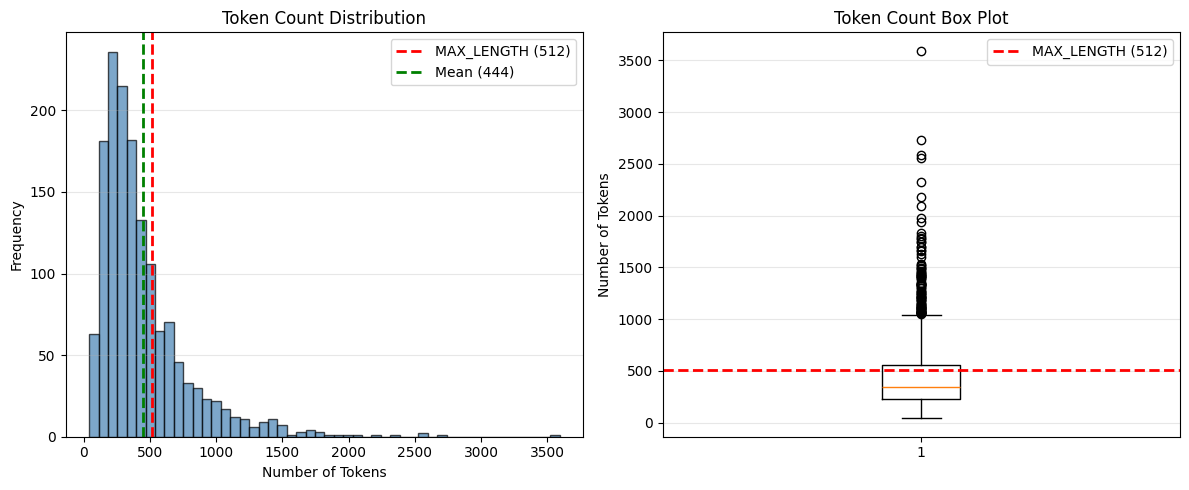

In [6]:
# Load dataset to inspect samples
sample_dataset = FixationsDataset(DATA_PATH)

# Calculate token statistics for all samples
print("Calculating token statistics for all samples...")
print("="*80)

token_counts = []

for i in tqdm(range(len(sample_dataset)), desc="Tokenizing samples"):
    sample = sample_dataset[i]
    text = sample['text']
    
    # Tokenize the text
    tokens = tokenizer(text, truncation=False, add_special_tokens=False)
    token_count = len(tokens['input_ids'])
    token_counts.append(token_count)

# Convert to numpy array for statistics
token_counts = np.array(token_counts)

# Calculate statistics
print(f"\nToken Count Statistics:")
print(f"  Total samples: {len(token_counts)}")
print(f"  Mean: {token_counts.mean():.2f}")
print(f"  Std: {token_counts.std():.2f}")
print(f"  Min: {token_counts.min()}")
print(f"  Max: {token_counts.max()}")
print(f"  Median: {np.median(token_counts):.2f}")
print(f"  25th percentile: {np.percentile(token_counts, 25):.2f}")
print(f"  75th percentile: {np.percentile(token_counts, 75):.2f}")
print(f"  95th percentile: {np.percentile(token_counts, 95):.2f}")
print(f"  99th percentile: {np.percentile(token_counts, 99):.2f}")

# Check how many samples exceed MAX_LENGTH
truncated_count = np.sum(token_counts > MAX_LENGTH)
print(f"\nSamples exceeding MAX_LENGTH ({MAX_LENGTH}): {truncated_count} ({100*truncated_count/len(token_counts):.2f}%)")

# Plot histogram
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(token_counts, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
plt.axvline(x=MAX_LENGTH, color='red', linestyle='--', linewidth=2, label=f'MAX_LENGTH ({MAX_LENGTH})')
plt.axvline(x=token_counts.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean ({token_counts.mean():.0f})')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Token Count Distribution')
plt.legend() 
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(token_counts, vert=True)
plt.axhline(y=MAX_LENGTH, color='red', linestyle='--', linewidth=2, label=f'MAX_LENGTH ({MAX_LENGTH})')
plt.ylabel('Number of Tokens')
plt.title('Token Count Box Plot')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Collate Function

Tokenize text sequences and prepare batch for BERT.

In [8]:
def collate_fn(batch):
    """Collate function for DataLoader with tokenization."""
    texts = [item['text'] for item in batch]
    labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)
    user_ids = [item['user_id'] for item in batch]
    
    # Tokenize texts
    encodings = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )
    
    return {
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': labels,
        'user_ids': user_ids
    }

## Training Function

In [9]:
def train_model(model, train_loader, optimizer, device):
    """Train model for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in tqdm(train_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
    
    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    
    return avg_loss, accuracy

## Evaluation Function

In [10]:
def evaluate_model(model, test_loader, device):
    """Evaluate model on test set."""
    model.eval()
    all_predictions = []
    all_labels = []
    total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            total_loss += loss.item()
            
            predictions = torch.argmax(logits, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(test_loader) if len(test_loader) > 0 else 0
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='binary', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='binary', zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average='binary', zero_division=0)
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_predictions,
        'labels': all_labels
    }

## LOUO Cross-Validation

Leave-One-User-Out: Train on all users except one, test on the held-out user.

In [11]:
# Load full dataset
print("Loading dataset...")
full_dataset = FixationsDataset(DATA_PATH)

# Get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Get unique users for LOUO
unique_users = full_dataset.get_unique_users()
print(f"Found {len(unique_users)} unique users: {unique_users}")

# Storage for results
all_fold_results = []

# LOUO Cross-Validation
for fold, test_user in enumerate(unique_users):
    print(f"\n{'='*60}")
    print(f"Fold {fold+1}/{len(unique_users)} - Testing on User {test_user}")
    print(f"{'='*60}")
    
    # Split dataset by user
    train_indices = [i for i, user_id in enumerate(full_dataset.get_user_ids()) if user_id != test_user]
    test_indices = [i for i, user_id in enumerate(full_dataset.get_user_ids()) if user_id == test_user]
    
    print(f"Train samples: {len(train_indices)}, Test samples: {len(test_indices)}")
    
    # Handle edge case: no test samples
    if len(test_indices) == 0:
        print(f"Warning: No test samples for user {test_user}, skipping...")
        continue
    
    # Create subsets
    train_dataset = Subset(full_dataset, train_indices)
    test_dataset = Subset(full_dataset, test_indices)
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn
    )
    
    # Initialize model for this fold
    model = BertForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2,
        
    )
    
    # Resize token embeddings to account for [ROW] token
    model.resize_token_embeddings(len(tokenizer))
    model = model.to(device)
    
    # Initialize optimizer
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    
    # Training loop
    best_val_f1 = 0
    
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        
        # Train
        train_loss, train_acc = train_model(model, train_loader, optimizer, device)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        
        # Evaluate
        results = evaluate_model(model, test_loader, device)
        print(f"Test Loss: {results['loss']:.4f}")
        print(f"Test Acc: {results['accuracy']:.4f}")
        print(f"Test Precision: {results['precision']:.4f}")
        print(f"Test Recall: {results['recall']:.4f}")
        print(f"Test F1: {results['f1']:.4f}")
    
    # Store final results for this fold
    final_results = evaluate_model(model, test_loader, device)
    final_results['test_user'] = test_user
    final_results['fold'] = fold
    all_fold_results.append(final_results)
    
    # Clean up
    del model, optimizer
    torch.cuda.empty_cache()

print(f"\n{'='*60}")
print("LOUO Cross-Validation Complete!")
print(f"{'='*60}")

Loading dataset...
Loaded 1499 samples from 30 users
Label distribution - Literate: 650, Illiterate: 849
Using device: cuda
Found 30 unique users: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]

Fold 1/30 - Testing on User 1
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`



Epoch 1/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6857, Train Acc: 0.5749


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.92it/s]


Test Loss: 0.8299
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [02:28<00:00,  2.45it/s]


Train Loss: 0.6872, Train Acc: 0.5659


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.94it/s]


Test Loss: 0.9748
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6895, Train Acc: 0.5783


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.93it/s]


Test Loss: 0.8083
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.47it/s]


Train Loss: 0.6690, Train Acc: 0.5839


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.92it/s]


Test Loss: 0.6847
Test Acc: 0.8800
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [02:28<00:00,  2.44it/s]


Train Loss: 0.6347, Train Acc: 0.6239


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.95it/s]


Test Loss: 1.4406
Test Acc: 0.1800
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.97it/s]



Fold 2/30 - Testing on User 2
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:29<00:00,  2.44it/s]


Train Loss: 0.7000, Train Acc: 0.5404


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.83it/s]


Test Loss: 0.5554
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [02:28<00:00,  2.45it/s]


Train Loss: 0.6916, Train Acc: 0.5362


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.93it/s]


Test Loss: 0.7369
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6850, Train Acc: 0.5493


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.89it/s]


Test Loss: 0.1621
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [02:28<00:00,  2.45it/s]


Train Loss: 0.6326, Train Acc: 0.6135


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.89it/s]


Test Loss: 0.2106
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [02:29<00:00,  2.43it/s]


Train Loss: 0.5823, Train Acc: 0.6805


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.87it/s]


Test Loss: 0.1700
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.98it/s]



Fold 3/30 - Testing on User 3
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.47it/s]


Train Loss: 0.6935, Train Acc: 0.5210


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.12it/s]


Test Loss: 0.5063
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.45it/s]


Train Loss: 0.6915, Train Acc: 0.5390


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.15it/s]


Test Loss: 0.4939
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.47it/s]


Train Loss: 0.6921, Train Acc: 0.5349


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.13it/s]


Test Loss: 0.5805
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.47it/s]


Train Loss: 0.6918, Train Acc: 0.5390


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.13it/s]


Test Loss: 0.5492
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6842, Train Acc: 0.5569


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.04it/s]


Test Loss: 0.6563
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.13it/s]



Fold 4/30 - Testing on User 4
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.47it/s]


Train Loss: 0.6951, Train Acc: 0.5521


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.25it/s]


Test Loss: 0.8647
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.47it/s]


Train Loss: 0.6857, Train Acc: 0.5763


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.25it/s]


Test Loss: 0.8822
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6879, Train Acc: 0.5618


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.26it/s]


Test Loss: 1.0624
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6881, Train Acc: 0.5604


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.27it/s]


Test Loss: 0.8014
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [02:28<00:00,  2.45it/s]


Train Loss: 0.6900, Train Acc: 0.5618


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.31it/s]


Test Loss: 0.9056
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.29it/s]



Fold 5/30 - Testing on User 6
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:28<00:00,  2.45it/s]


Train Loss: 0.6949, Train Acc: 0.5280


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 10.63it/s]


Test Loss: 0.6371
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6859, Train Acc: 0.5452


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 10.59it/s]


Test Loss: 0.4098
Test Acc: 0.9800
Test Precision: 1.0000
Test Recall: 0.9800
Test F1: 0.9899

Epoch 3/5


Training: 100%|██████████| 363/363 [02:28<00:00,  2.45it/s]


Train Loss: 0.6190, Train Acc: 0.6694


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 10.73it/s]


Test Loss: 0.3078
Test Acc: 0.9400
Test Precision: 1.0000
Test Recall: 0.9400
Test F1: 0.9691

Epoch 4/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.5691, Train Acc: 0.6998


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 10.71it/s]


Test Loss: 0.3017
Test Acc: 0.9200
Test Precision: 1.0000
Test Recall: 0.9200
Test F1: 0.9583

Epoch 5/5


Training: 100%|██████████| 363/363 [02:28<00:00,  2.45it/s]


Train Loss: 0.5418, Train Acc: 0.7219


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 10.64it/s]


Test Loss: 0.2246
Test Acc: 0.9800
Test Precision: 1.0000
Test Recall: 0.9800
Test F1: 0.9899


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 10.70it/s]



Fold 6/30 - Testing on User 7
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.47it/s]


Train Loss: 0.6890, Train Acc: 0.5466


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.70it/s]


Test Loss: 0.9659
Test Acc: 0.0400
Test Precision: 1.0000
Test Recall: 0.0400
Test F1: 0.0769

Epoch 2/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6769, Train Acc: 0.5659


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.74it/s]


Test Loss: 0.5916
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.47it/s]


Train Loss: 0.6344, Train Acc: 0.6294


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.68it/s]


Test Loss: 0.7630
Test Acc: 0.1400
Test Precision: 1.0000
Test Recall: 0.1400
Test F1: 0.2456

Epoch 4/5


Training: 100%|██████████| 363/363 [02:28<00:00,  2.45it/s]


Train Loss: 0.5489, Train Acc: 0.7157


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.74it/s]


Test Loss: 0.8532
Test Acc: 0.1600
Test Precision: 1.0000
Test Recall: 0.1600
Test F1: 0.2759

Epoch 5/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.45it/s]


Train Loss: 0.5097, Train Acc: 0.7295


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.69it/s]


Test Loss: 1.0794
Test Acc: 0.1000
Test Precision: 1.0000
Test Recall: 0.1000
Test F1: 0.1818


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.71it/s]



Fold 7/30 - Testing on User 8
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:28<00:00,  2.45it/s]


Train Loss: 0.6891, Train Acc: 0.5673


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.57it/s]


Test Loss: 0.8295
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.47it/s]


Train Loss: 0.6636, Train Acc: 0.5949


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


Test Loss: 0.7974
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [02:28<00:00,  2.45it/s]


Train Loss: 0.6394, Train Acc: 0.6115


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.54it/s]


Test Loss: 0.3634
Test Acc: 0.9400
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.5749, Train Acc: 0.6860


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.54it/s]


Test Loss: 0.4876
Test Acc: 0.9200
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.45it/s]


Train Loss: 0.5510, Train Acc: 0.7150


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.57it/s]


Test Loss: 0.4899
Test Acc: 0.9600
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.60it/s]



Fold 8/30 - Testing on User 9
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.47it/s]


Train Loss: 0.6870, Train Acc: 0.5714


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.00it/s]


Test Loss: 0.8882
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6814, Train Acc: 0.5825


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.05it/s]


Test Loss: 0.8726
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.47it/s]


Train Loss: 0.6842, Train Acc: 0.5721


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.97it/s]


Test Loss: 1.1355
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.47it/s]


Train Loss: 0.6886, Train Acc: 0.5631


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.05it/s]


Test Loss: 0.8611
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.6847, Train Acc: 0.5638


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.06it/s]


Test Loss: 1.0741
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.09it/s]



Fold 9/30 - Testing on User 10
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6886, Train Acc: 0.5707


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.41it/s]


Test Loss: 1.1554
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.47it/s]


Train Loss: 0.6251, Train Acc: 0.6494


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.42it/s]


Test Loss: 0.8622
Test Acc: 0.3800
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.45it/s]


Train Loss: 0.6065, Train Acc: 0.6598


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.36it/s]


Test Loss: 0.7606
Test Acc: 0.5600
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [02:25<00:00,  2.49it/s]


Train Loss: 0.5530, Train Acc: 0.7136


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.36it/s]


Test Loss: 1.3737
Test Acc: 0.1000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [02:25<00:00,  2.49it/s]


Train Loss: 0.5365, Train Acc: 0.7177


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.42it/s]


Test Loss: 1.3341
Test Acc: 0.4600
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.41it/s]



Fold 10/30 - Testing on User 11
Train samples: 1450, Test samples: 49


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.7098, Train Acc: 0.5214


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 10.48it/s]


Test Loss: 0.6605
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6983, Train Acc: 0.5159


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 10.57it/s]


Test Loss: 0.6048
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.6898, Train Acc: 0.5407


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 10.48it/s]


Test Loss: 0.6055
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.47it/s]


Train Loss: 0.6917, Train Acc: 0.5345


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 10.50it/s]


Test Loss: 0.4617
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.45it/s]


Train Loss: 0.6903, Train Acc: 0.5448


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 10.55it/s]


Test Loss: 0.6686
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 10.53it/s]



Fold 11/30 - Testing on User 12
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:28<00:00,  2.45it/s]


Train Loss: 0.6711, Train Acc: 0.5866


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.43it/s]


Test Loss: 1.6363
Test Acc: 0.1000
Test Precision: 1.0000
Test Recall: 0.1000
Test F1: 0.1818

Epoch 2/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.6024, Train Acc: 0.6818


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.47it/s]


Test Loss: 0.7493
Test Acc: 0.5800
Test Precision: 1.0000
Test Recall: 0.5800
Test F1: 0.7342

Epoch 3/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.5465, Train Acc: 0.7150


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.48it/s]


Test Loss: 0.8665
Test Acc: 0.6000
Test Precision: 1.0000
Test Recall: 0.6000
Test F1: 0.7500

Epoch 4/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.5041, Train Acc: 0.7447


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.46it/s]


Test Loss: 0.6726
Test Acc: 0.6000
Test Precision: 1.0000
Test Recall: 0.6000
Test F1: 0.7500

Epoch 5/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.47it/s]


Train Loss: 0.4832, Train Acc: 0.7605


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.46it/s]


Test Loss: 0.5676
Test Acc: 0.6200
Test Precision: 1.0000
Test Recall: 0.6200
Test F1: 0.7654


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.43it/s]



Fold 12/30 - Testing on User 13
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.45it/s]


Train Loss: 0.7029, Train Acc: 0.5176


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.20it/s]


Test Loss: 0.5423
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.45it/s]


Train Loss: 0.6638, Train Acc: 0.6066


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.17it/s]


Test Loss: 0.3745
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.6127, Train Acc: 0.6391


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.26it/s]


Test Loss: 0.5227
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [02:28<00:00,  2.45it/s]


Train Loss: 0.5832, Train Acc: 0.6805


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.21it/s]


Test Loss: 0.3747
Test Acc: 0.9200
Test Precision: 1.0000
Test Recall: 0.9200
Test F1: 0.9583

Epoch 5/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.47it/s]


Train Loss: 0.5436, Train Acc: 0.7115


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.24it/s]


Test Loss: 0.2213
Test Acc: 0.9000
Test Precision: 1.0000
Test Recall: 0.9000
Test F1: 0.9474


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.23it/s]



Fold 13/30 - Testing on User 14
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6928, Train Acc: 0.5438


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.66it/s]


Test Loss: 1.1290
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.45it/s]


Train Loss: 0.6846, Train Acc: 0.5749


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.66it/s]


Test Loss: 1.1488
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.47it/s]


Train Loss: 0.6382, Train Acc: 0.6184


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.65it/s]


Test Loss: 0.7777
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [02:28<00:00,  2.45it/s]


Train Loss: 0.6106, Train Acc: 0.6577


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.59it/s]


Test Loss: 0.8987
Test Acc: 0.5000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.47it/s]


Train Loss: 0.5361, Train Acc: 0.7308


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.66it/s]


Test Loss: 1.0245
Test Acc: 0.1600
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.68it/s]
'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 4a0f8a32-00c8-45dc-86e1-73fb9c8c8430)')' thrown while requesting HEAD https://huggingface.co/bert-base-uncased/resolve/main/config.json
Retrying in 1s [Retry 1/5].



Fold 14/30 - Testing on User 15
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6973, Train Acc: 0.5362


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 10.57it/s]


Test Loss: 0.5559
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6851, Train Acc: 0.5852


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 10.50it/s]


Test Loss: 0.7495
Test Acc: 0.4600
Test Precision: 1.0000
Test Recall: 0.4600
Test F1: 0.6301

Epoch 3/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.47it/s]


Train Loss: 0.6831, Train Acc: 0.5583


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 10.51it/s]


Test Loss: 0.5370
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [02:28<00:00,  2.44it/s]


Train Loss: 0.6911, Train Acc: 0.5445


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 10.65it/s]


Test Loss: 0.4347
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6948, Train Acc: 0.5369


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 10.64it/s]


Test Loss: 0.6362
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 10.58it/s]



Fold 15/30 - Testing on User 16
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.47it/s]


Train Loss: 0.6962, Train Acc: 0.5493


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.76it/s]


Test Loss: 0.9660
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.6858, Train Acc: 0.5714


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.70it/s]


Test Loss: 0.9969
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.47it/s]


Train Loss: 0.6818, Train Acc: 0.5804


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.79it/s]


Test Loss: 0.9000
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.47it/s]


Train Loss: 0.6875, Train Acc: 0.5756


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.81it/s]


Test Loss: 0.9944
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.6808, Train Acc: 0.5839


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.69it/s]


Test Loss: 0.7269
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.68it/s]



Fold 16/30 - Testing on User 17
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6982, Train Acc: 0.5342


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 16.00it/s]


Test Loss: 0.6589
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.45it/s]


Train Loss: 0.6933, Train Acc: 0.5266


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 16.13it/s]


Test Loss: 0.5831
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6849, Train Acc: 0.5638


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 16.10it/s]


Test Loss: 0.5609
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [02:28<00:00,  2.44it/s]


Train Loss: 0.6886, Train Acc: 0.5507


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 16.13it/s]


Test Loss: 0.4099
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.7039, Train Acc: 0.5431


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 16.00it/s]


Test Loss: 0.6570
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 16.16it/s]



Fold 17/30 - Testing on User 18
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.6899, Train Acc: 0.5362


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.52it/s]


Test Loss: 0.7127
Test Acc: 0.1400
Test Precision: 1.0000
Test Recall: 0.1400
Test F1: 0.2456

Epoch 2/5


Training: 100%|██████████| 363/363 [02:25<00:00,  2.50it/s]


Train Loss: 0.6096, Train Acc: 0.6563


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.52it/s]


Test Loss: 0.2714
Test Acc: 0.9000
Test Precision: 1.0000
Test Recall: 0.9000
Test F1: 0.9474

Epoch 3/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.47it/s]


Train Loss: 0.5543, Train Acc: 0.7115


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.49it/s]


Test Loss: 0.3651
Test Acc: 0.9200
Test Precision: 1.0000
Test Recall: 0.9200
Test F1: 0.9583

Epoch 4/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.47it/s]


Train Loss: 0.5177, Train Acc: 0.7177


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.46it/s]


Test Loss: 0.2077
Test Acc: 0.9000
Test Precision: 1.0000
Test Recall: 0.9000
Test F1: 0.9474

Epoch 5/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.5090, Train Acc: 0.7302


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.47it/s]


Test Loss: 0.3365
Test Acc: 0.7400
Test Precision: 1.0000
Test Recall: 0.7400
Test F1: 0.8506


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.51it/s]



Fold 18/30 - Testing on User 19
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:25<00:00,  2.49it/s]


Train Loss: 0.6957, Train Acc: 0.5321


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.00it/s]


Test Loss: 0.6150
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.6806, Train Acc: 0.5763


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.97it/s]


Test Loss: 0.7147
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6768, Train Acc: 0.5590


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.95it/s]


Test Loss: 0.5170
Test Acc: 0.9000
Test Precision: 1.0000
Test Recall: 0.9000
Test F1: 0.9474

Epoch 4/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.6663, Train Acc: 0.5742


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.00it/s]


Test Loss: 0.7750
Test Acc: 0.3600
Test Precision: 1.0000
Test Recall: 0.3600
Test F1: 0.5294

Epoch 5/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.5736, Train Acc: 0.6984


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.01it/s]


Test Loss: 0.6287
Test Acc: 0.3600
Test Precision: 1.0000
Test Recall: 0.3600
Test F1: 0.5294


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.04it/s]



Fold 19/30 - Testing on User 21
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6926, Train Acc: 0.5473


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.65it/s]


Test Loss: 0.9361
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.49it/s]


Train Loss: 0.6899, Train Acc: 0.5694


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.62it/s]


Test Loss: 0.8649
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.6841, Train Acc: 0.5763


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.69it/s]


Test Loss: 0.8128
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.6468, Train Acc: 0.6163


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.69it/s]


Test Loss: 0.6733
Test Acc: 0.6600
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.5821, Train Acc: 0.6674


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.65it/s]


Test Loss: 0.6648
Test Acc: 0.6800
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.68it/s]



Fold 20/30 - Testing on User 22
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.6940, Train Acc: 0.5369


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.88it/s]


Test Loss: 1.3705
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.6808, Train Acc: 0.5528


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.90it/s]


Test Loss: 0.4276
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.6127, Train Acc: 0.6680


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.89it/s]


Test Loss: 1.0250
Test Acc: 0.0600
Test Precision: 1.0000
Test Recall: 0.0600
Test F1: 0.1132

Epoch 4/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.47it/s]


Train Loss: 0.5580, Train Acc: 0.7308


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.86it/s]


Test Loss: 0.9448
Test Acc: 0.0600
Test Precision: 1.0000
Test Recall: 0.0600
Test F1: 0.1132

Epoch 5/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.5322, Train Acc: 0.7302


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.91it/s]


Test Loss: 0.8801
Test Acc: 0.2000
Test Precision: 1.0000
Test Recall: 0.2000
Test F1: 0.3333


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.93it/s]



Fold 21/30 - Testing on User 23
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6869, Train Acc: 0.5680


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  9.62it/s]


Test Loss: 0.9326
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.47it/s]


Train Loss: 0.6830, Train Acc: 0.5880


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  9.57it/s]


Test Loss: 0.9762
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [02:28<00:00,  2.44it/s]


Train Loss: 0.6715, Train Acc: 0.5783


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  9.59it/s]


Test Loss: 0.9143
Test Acc: 0.2200
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.47it/s]


Train Loss: 0.5937, Train Acc: 0.6867


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  9.60it/s]


Test Loss: 0.5700
Test Acc: 0.8000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.47it/s]


Train Loss: 0.5486, Train Acc: 0.7046


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  9.61it/s]


Test Loss: 0.6287
Test Acc: 0.8400
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  9.65it/s]



Fold 22/30 - Testing on User 24
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:25<00:00,  2.49it/s]


Train Loss: 0.6639, Train Acc: 0.5832


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.43it/s]


Test Loss: 0.7642
Test Acc: 0.3800
Test Precision: 1.0000
Test Recall: 0.3800
Test F1: 0.5507

Epoch 2/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.47it/s]


Train Loss: 0.5778, Train Acc: 0.7019


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.46it/s]


Test Loss: 1.1405
Test Acc: 0.0400
Test Precision: 1.0000
Test Recall: 0.0400
Test F1: 0.0769

Epoch 3/5


Training: 100%|██████████| 363/363 [02:25<00:00,  2.49it/s]


Train Loss: 0.5316, Train Acc: 0.7371


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.42it/s]


Test Loss: 1.0928
Test Acc: 0.1000
Test Precision: 1.0000
Test Recall: 0.1000
Test F1: 0.1818

Epoch 4/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.47it/s]


Train Loss: 0.4940, Train Acc: 0.7467


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.45it/s]


Test Loss: 2.3103
Test Acc: 0.0400
Test Precision: 1.0000
Test Recall: 0.0400
Test F1: 0.0769

Epoch 5/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.4754, Train Acc: 0.7598


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.43it/s]


Test Loss: 1.3319
Test Acc: 0.0600
Test Precision: 1.0000
Test Recall: 0.0600
Test F1: 0.1132


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.44it/s]



Fold 23/30 - Testing on User 25
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.6951, Train Acc: 0.5507


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  9.40it/s]


Test Loss: 0.6290
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6916, Train Acc: 0.5328


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  9.37it/s]


Test Loss: 0.5105
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6946, Train Acc: 0.5369


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  9.40it/s]


Test Loss: 0.4836
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.6965, Train Acc: 0.5459


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  9.43it/s]


Test Loss: 0.6316
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.45it/s]


Train Loss: 0.6951, Train Acc: 0.5390


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  9.40it/s]


Test Loss: 0.7092
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  9.45it/s]



Fold 24/30 - Testing on User 26
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.47it/s]


Train Loss: 0.6906, Train Acc: 0.5631


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.12it/s]


Test Loss: 1.2420
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.47it/s]


Train Loss: 0.6839, Train Acc: 0.5790


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.12it/s]


Test Loss: 0.7705
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.6852, Train Acc: 0.5638


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.14it/s]


Test Loss: 0.9265
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [02:25<00:00,  2.49it/s]


Train Loss: 0.6850, Train Acc: 0.5618


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.09it/s]


Test Loss: 0.9615
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.6844, Train Acc: 0.5845


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.12it/s]


Test Loss: 0.8305
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.13it/s]



Fold 25/30 - Testing on User 27
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6960, Train Acc: 0.5369


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  9.70it/s]


Test Loss: 0.6694
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.47it/s]


Train Loss: 0.6602, Train Acc: 0.6163


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  9.69it/s]


Test Loss: 0.4431
Test Acc: 0.8000
Test Precision: 1.0000
Test Recall: 0.8000
Test F1: 0.8889

Epoch 3/5


Training: 100%|██████████| 363/363 [02:28<00:00,  2.45it/s]


Train Loss: 0.5888, Train Acc: 0.6777


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  9.63it/s]


Test Loss: 0.7413
Test Acc: 0.4200
Test Precision: 1.0000
Test Recall: 0.4200
Test F1: 0.5915

Epoch 4/5


Training: 100%|██████████| 363/363 [02:28<00:00,  2.45it/s]


Train Loss: 0.5649, Train Acc: 0.6936


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  9.69it/s]


Test Loss: 0.7498
Test Acc: 0.4200
Test Precision: 1.0000
Test Recall: 0.4200
Test F1: 0.5915

Epoch 5/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.5327, Train Acc: 0.7198


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  9.62it/s]


Test Loss: 0.5132
Test Acc: 0.6000
Test Precision: 1.0000
Test Recall: 0.6000
Test F1: 0.7500


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  9.67it/s]



Fold 26/30 - Testing on User 28
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.45it/s]


Train Loss: 0.6956, Train Acc: 0.5514


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 10.98it/s]


Test Loss: 0.9894
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.47it/s]


Train Loss: 0.6872, Train Acc: 0.5735


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 11.07it/s]


Test Loss: 0.9520
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.6849, Train Acc: 0.5749


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 11.06it/s]


Test Loss: 0.7083
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.6909, Train Acc: 0.5631


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 11.01it/s]


Test Loss: 0.9808
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [02:28<00:00,  2.45it/s]


Train Loss: 0.6857, Train Acc: 0.5556


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 11.03it/s]


Test Loss: 0.7588
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 11.11it/s]



Fold 27/30 - Testing on User 29
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6904, Train Acc: 0.5535


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.60it/s]


Test Loss: 0.8116
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.47it/s]


Train Loss: 0.6893, Train Acc: 0.5604


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.66it/s]


Test Loss: 0.9093
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.45it/s]


Train Loss: 0.6831, Train Acc: 0.5728


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.63it/s]


Test Loss: 0.9444
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.47it/s]


Train Loss: 0.6822, Train Acc: 0.5804


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.65it/s]


Test Loss: 0.6985
Test Acc: 0.1800
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6732, Train Acc: 0.5756


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.61it/s]


Test Loss: 0.8879
Test Acc: 0.6200
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  8.62it/s]



Fold 28/30 - Testing on User 30
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.7000, Train Acc: 0.5148


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.70it/s]


Test Loss: 0.6027
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [02:25<00:00,  2.49it/s]


Train Loss: 0.6990, Train Acc: 0.5107


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.69it/s]


Test Loss: 0.6915
Test Acc: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6941, Train Acc: 0.5321


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.66it/s]


Test Loss: 0.7042
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [02:26<00:00,  2.48it/s]


Train Loss: 0.6968, Train Acc: 0.5390


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.61it/s]


Test Loss: 0.6962
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.47it/s]


Train Loss: 0.6903, Train Acc: 0.5411


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.65it/s]


Test Loss: 0.6691
Test Acc: 0.5600
Test Precision: 1.0000
Test Recall: 0.5600
Test F1: 0.7179


Evaluating: 100%|██████████| 13/13 [00:01<00:00,  7.69it/s]



Fold 29/30 - Testing on User 31
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.47it/s]


Train Loss: 0.6833, Train Acc: 0.5742


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 12.57it/s]


Test Loss: 0.7945
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 2/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6805, Train Acc: 0.5707


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 12.52it/s]


Test Loss: 0.8499
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 3/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6827, Train Acc: 0.5694


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 12.57it/s]


Test Loss: 0.8817
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 4/5


Training: 100%|██████████| 363/363 [02:28<00:00,  2.45it/s]


Train Loss: 0.6629, Train Acc: 0.5839


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 12.59it/s]


Test Loss: 0.8669
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000

Epoch 5/5


Training: 100%|██████████| 363/363 [02:28<00:00,  2.45it/s]


Train Loss: 0.6564, Train Acc: 0.5866


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 12.56it/s]


Test Loss: 1.0483
Test Acc: 0.0000
Test Precision: 0.0000
Test Recall: 0.0000
Test F1: 0.0000


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 12.55it/s]



Fold 30/30 - Testing on User 32
Train samples: 1449, Test samples: 50


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5


Training: 100%|██████████| 363/363 [02:27<00:00,  2.46it/s]


Train Loss: 0.6770, Train Acc: 0.5707


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 11.83it/s]


Test Loss: 0.4277
Test Acc: 0.7800
Test Precision: 1.0000
Test Recall: 0.7800
Test F1: 0.8764

Epoch 2/5


Training: 100%|██████████| 363/363 [02:28<00:00,  2.45it/s]


Train Loss: 0.6030, Train Acc: 0.6749


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 11.85it/s]


Test Loss: 0.3964
Test Acc: 0.9600
Test Precision: 1.0000
Test Recall: 0.9600
Test F1: 0.9796

Epoch 3/5


Training: 100%|██████████| 363/363 [02:28<00:00,  2.44it/s]


Train Loss: 0.5807, Train Acc: 0.6936


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 11.78it/s]


Test Loss: 0.5219
Test Acc: 0.6800
Test Precision: 1.0000
Test Recall: 0.6800
Test F1: 0.8095

Epoch 4/5


Training: 100%|██████████| 363/363 [02:28<00:00,  2.45it/s]


Train Loss: 0.5481, Train Acc: 0.7012


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 11.77it/s]


Test Loss: 0.3597
Test Acc: 0.9000
Test Precision: 1.0000
Test Recall: 0.9000
Test F1: 0.9474

Epoch 5/5


Training: 100%|██████████| 363/363 [02:28<00:00,  2.45it/s]


Train Loss: 0.5218, Train Acc: 0.7136


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 11.77it/s]


Test Loss: 0.3084
Test Acc: 0.8600
Test Precision: 1.0000
Test Recall: 0.8600
Test F1: 0.9247


Evaluating: 100%|██████████| 13/13 [00:01<00:00, 11.86it/s]


LOUO Cross-Validation Complete!


## Aggregate Results Across Folds

In [12]:
# Calculate mean and std across all folds
if len(all_fold_results) > 0:
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    print("\n" + "="*60)
    print("LOUO Cross-Validation Results Summary")
    print("="*60)
    
    for metric in metrics:
        values = [result[metric] for result in all_fold_results]
        mean_val = np.mean(values)
        std_val = np.std(values)
        print(f"{metric.capitalize():12s}: {mean_val:.4f} ± {std_val:.4f}")
    
    # Create results dataframe
    results_df = pd.DataFrame([
        {
            'fold': r['fold'],
            'test_user': r['test_user'],
            'accuracy': r['accuracy'],
            'precision': r['precision'],
            'recall': r['recall'],
            'f1': r['f1']
        }
        for r in all_fold_results
    ])
    
    print("\nPer-Fold Results:")
    print(results_df.to_string(index=False))
else:
    print("No results to aggregate")


LOUO Cross-Validation Results Summary
Accuracy    : 0.4960 ± 0.3942
Precision   : 0.5333 ± 0.4989
Recall      : 0.3660 ± 0.4195
F1          : 0.4035 ± 0.4349

Per-Fold Results:
 fold  test_user  accuracy  precision  recall       f1
    0          1      0.18        0.0    0.00 0.000000
    1          2      1.00        1.0    1.00 1.000000
    2          3      1.00        1.0    1.00 1.000000
    3          4      0.00        0.0    0.00 0.000000
    4          6      0.98        1.0    0.98 0.989899
    5          7      0.10        1.0    0.10 0.181818
    6          8      0.96        0.0    0.00 0.000000
    7          9      0.00        0.0    0.00 0.000000
    8         10      0.46        0.0    0.00 0.000000
    9         11      1.00        1.0    1.00 1.000000
   10         12      0.62        1.0    0.62 0.765432
   11         13      0.90        1.0    0.90 0.947368
   12         14      0.16        0.0    0.00 0.000000
   13         15      1.00        1.0    1.00 1.0000

## Visualize Results

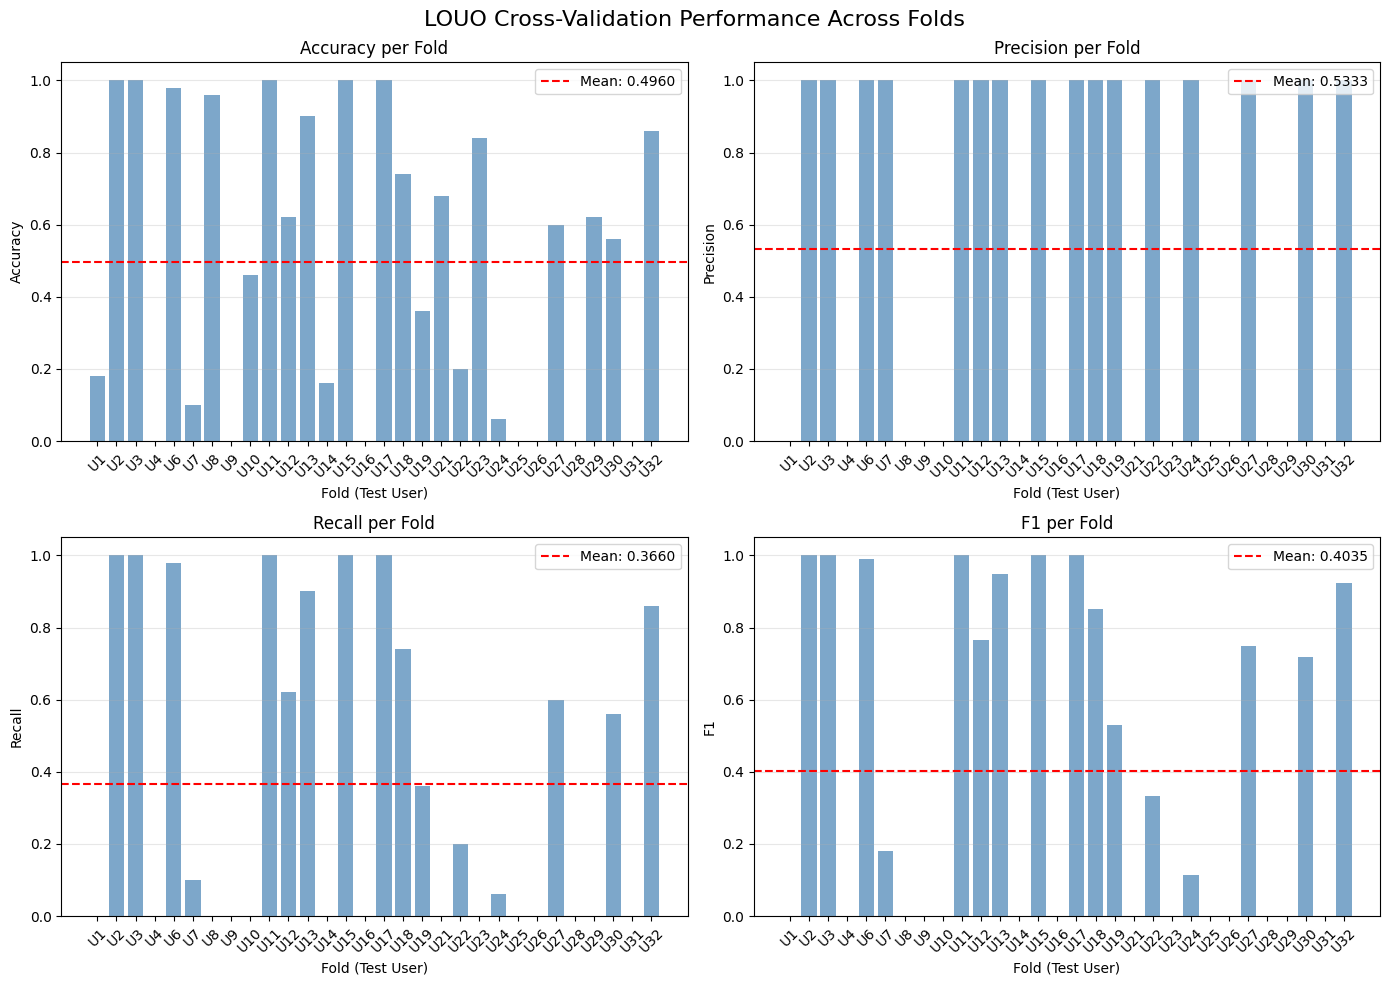

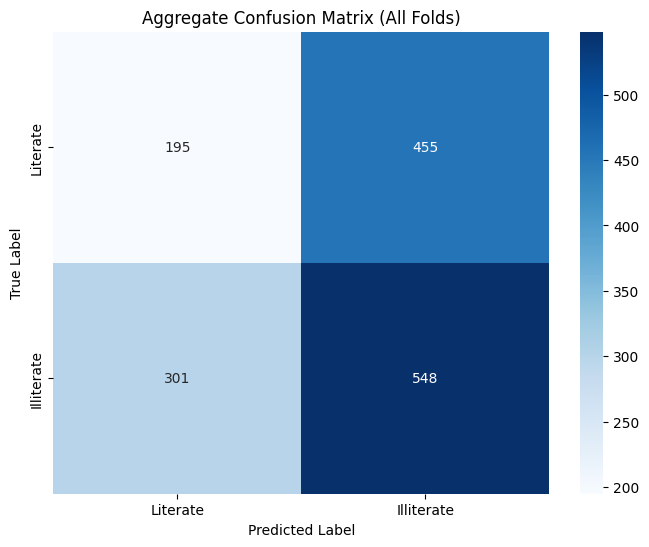

In [13]:
if len(all_fold_results) > 0:
    # Plot metrics across folds
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('LOUO Cross-Validation Performance Across Folds', fontsize=16)
    
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1']
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx // 2, idx % 2]
        values = [result[metric] for result in all_fold_results]
        users = [result['test_user'] for result in all_fold_results]
        
        ax.bar(range(len(values)), values, color='steelblue', alpha=0.7)
        ax.axhline(y=np.mean(values), color='red', linestyle='--', label=f'Mean: {np.mean(values):.4f}')
        ax.set_xlabel('Fold (Test User)')
        ax.set_ylabel(metric.capitalize())
        ax.set_title(f'{metric.capitalize()} per Fold')
        ax.set_xticks(range(len(users)))
        ax.set_xticklabels([f"U{u}" for u in users], rotation=45)
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Plot confusion matrix (aggregate)
    all_predictions = []
    all_labels = []
    for result in all_fold_results:
        all_predictions.extend(result['predictions'])
        all_labels.extend(result['labels'])
    
    cm = confusion_matrix(all_labels, all_predictions)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Literate', 'Illiterate'],
                yticklabels=['Literate', 'Illiterate'])
    plt.title('Aggregate Confusion Matrix (All Folds)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
else:
    print("No results to visualize")